# Generating radio signals

In [36]:
# Imports and boilerplate to make graphs look better
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy
import wave
from IPython.display import Audio

def setup_graph(title='', x_label='', y_label='', fig_size=None):
    fig = plt.figure()
    if fig_size != None:
        fig.set_size_inches(fig_size[0], fig_size[1])
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

## Basic wave functions

In [37]:
SAMPLE_BITSIZE = 16
MAX_AMP_16BIT = int(2**SAMPLE_BITSIZE/2 - 1)

def generate_wave(freq, len_in_sec=1, samp_rate=44100, amplitude=MAX_AMP_16BIT):
    t = np.linspace(0, len_in_sec, samp_rate * len_in_sec)
    sig = amplitude * np.sin(freq * 2 * np.pi * t) 
    return sig

def write_wav_file(file_path, wav_data, sample_rate=44100, num_channels=1):
    f = wave.open(file_path, 'wb')
    f.setparams((num_channels, 2, sample_rate, len(wav_data), "NONE", "Uncompressed"))
    f.writeframes(np.array(wav_data, dtype=np.int16))
    f.close()

def write_pcm_file(signal_data, file_path, dtype='complex64'):
    np.array(signal_data).astype('complex64').tofile(file_path)

# Amplitude modulation

First, we need to figure out how to modulate the amplitude of the carrier wave to "high amplitude" and "low amplitude" to correspond with the binary"s and 0s.

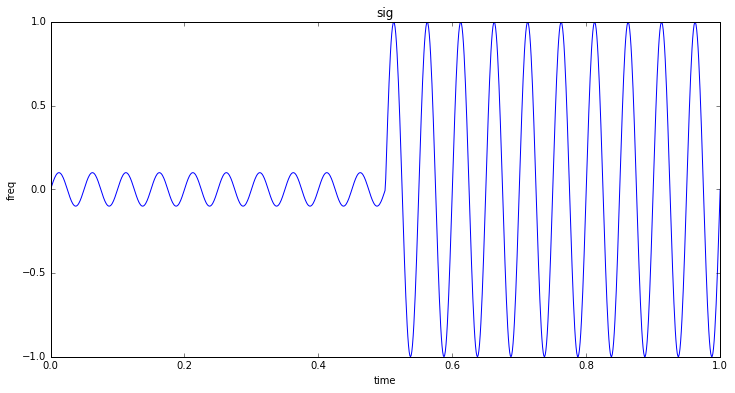

In [38]:
samp_rate = 1000
len_in_sec = 1
carrier_freq = 20

low_amp = 0.1
high_amp = 1

t = np.linspace(0, 1, samp_rate * len_in_sec)
carrier = 1*np.sin(carrier_freq * 2 * np.pi * t)

# Modulate with the binary signal: ['0', '1']
amp_mult = np.array([low_amp]*500 + [high_amp]*500)
sig = amp_mult * carrier

setup_graph(title='sig', x_label='time', y_label='freq', fig_size=(12,6))
plt.plot(t, sig)

So looking at the above example, let's see how we calculate the size of the multiplier array...

* The carrier frequency is 20Hz.
* The baud, in this case, is 2 bits per second, which is why we need 1 second to contain the 2 bits.
* The size of the multiplier wave to modulate the carrier wave is 1000 in size because it must match the number of samples there are (which in this case, 1 second x 1000 samples per second = 1000).
* Note the width of each bit (in terms of samples) is samples_per_second / bits_per_second = 1000 / 2 = 500

## Write function to modulate amplitude according to binary data

To modulate the carrier wave signal, we will simply:
* Generate the carrier wave
* Generate a "modulation array" - an array with the LOW or HIGH amplitudes for each data point in the carrier wave array
* Multiply the "carrier wave array" with the "modulation array", to result in the "modulated signal"

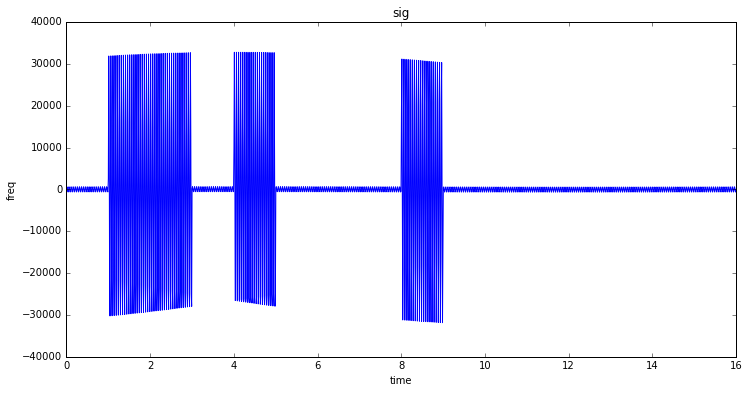

In [58]:
SAMPLE_BITSIZE = 16
MAX_AMP_16BIT = int(2**SAMPLE_BITSIZE/2 - 1)

DEFAULT_RATIOS = {
    '_': 1,
    '0': 1,
    '1': 3
}

DEFAULT_AMP_MAP = {
    '0': MAX_AMP_16BIT * .02,
    '1': MAX_AMP_16BIT
}

def get_modulation_array(binary_data, sample_rate, baud, sig_ratios, amp_map, dtype=np.int16):
    data_points_in_bit = int(sample_rate * 1/baud)
    modulation_array = np.array([], dtype=dtype)

    for bit in binary_data:
        bit_amplitude = amp_map[bit]
        modulated_bit = np.full(data_points_in_bit, bit_amplitude, dtype=np.int16)
        modulation_array = np.append(modulation_array, modulated_bit)
    return modulation_array

def generate_on_off_key_signal(binary_data, carrier_wave_freq, sample_rate,
                               baud, sig_ratios=DEFAULT_RATIOS, amp_map=DEFAULT_AMP_MAP, dtype=np.int16):
    signal_len_secs = len(binary_data) * (1/baud)
    t = np.linspace(0, signal_len_secs, sample_rate * signal_len_secs)
    
    carrier_wave = 1 * np.sin(carrier_wave_freq * 2 * np.pi * t)
    modulation_array = get_modulation_array(binary_data, sample_rate, baud, sig_ratios, amp_map, dtype)
    return t, carrier_wave * modulation_array
    

binary_data = '0110100010000000'
carrier_wave_freq = 20 #315e6
sample_rate = 100
baud = 1

t, sig = generate_on_off_key_signal(binary_data, carrier_wave_freq, sample_rate, baud)
setup_graph(title='sig', x_label='time', y_label='freq', fig_size=(12,6))
plt.plot(t, sig)

Sweet! So it looks like it roughly worked. But there is a problem: we have no breaks between bits (so a group of 1's looks like a single pulse). Let's fix that...